In [1]:
import pandas as pd
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# manually define building names
buildingnames = ['YUAG',
                 'Berkeley',
                 'Hopper',
                 '304Elm',
                 'Davenport',
                 '38HH',
                 '320Temple',
                 '53Wall',
                 'Sprague',
                 'Malone',
                 'Trumbull',
                 '17HH']

# Consumption Data

In [3]:
# read from csv into a new dataframe
raw = pd.read_csv('energy_raw.csv',index_col=0,na_values=['#########'])

# reindex by appropriate datetime
raw.index = pd.to_datetime(raw.index,format='%a %m/%d/%y %H:00')

# add missing rows by full reindexing
correct_dt = pd.DatetimeIndex(start='2018-01-01 00:00:00',end='2018-07-27 23:00:00',freq='h')
raw = raw.reindex(index=correct_dt)

# remove built-in demand values, which tend to be bugged
raw = raw.drop(raw.columns[np.arange(0,len(buildingnames)*2,2)], axis=1)

# rename columns accordingly
raw.columns = buildingnames

In [4]:
# save the first five rows to replace later
raw_head = raw.head(1)
raw.describe()

,YUAG,Berkeley,Hopper,304Elm,Davenport,38HH,320Temple,53Wall,Sprague,Malone,Trumbull,17HH
count,4.991000e+03,4.991000e+03,4.991000e+03,4.991000e+03,4.991000e+03,4.991000e+03,4991.000000,4.991000e+03,4991.000000,4.991000e+03,4.991000e+03,4.991000e+03
mean,8.414169e+06,7.465573e+06,3.018159e+06,1.126277e+06,3.762755e+06,3.174013e+06,98637.747986,3.063754e+06,474177.614165,6.874799e+06,4.683953e+06,9.281003e+06
std,3.459993e+05,2.250370e+05,1.562374e+05,2.962100e+04,1.778626e+06,7.818495e+04,3551.134045,1.055216e+05,68154.385968,2.579452e+05,2.030521e+05,3.794849e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.179947e+06,7.357006e+06,2.904148e+06,1.117832e+06,4.347668e+06,3.169707e+06,96601.150000,3.047126e+06,416066.650000,6.710571e+06,4.563672e+06,9.111269e+06
50%,8.422790e+06,7.475622e+06,3.029166e+06,1.126659e+06,4.542060e+06,3.175551e+06,98763.800000,3.072880e+06,477017.800000,6.875171e+06,4.697258e+06,9.310198e+06
75%,8.660219e+06,7.583298e+06,3.145485e+06,1.135486e+06,4.715319e+06,3.181725e+06,100783.900000,3.097860e+06,533968.150000,7.047997e+06,4.817691e+06,9.500518e+06
max,8.892998e+06,7.692876e+06,3.229248e+06,1.149326e+06,4.869747e+06,3.190141e+06,103489.700000,3.122056e+06,583831.300000,7.221004e+06,4.933964e+06,9.681342e+06


In [5]:
# remove impossible outliers based on the percent change, limited by tau
raw = raw.where(raw.pct_change(limit=1)>0)

# tau = 0.0005 * (raw.max()-raw.min())
# raw = raw.where(raw.pct_change(limit=1)<tau)

# replace consumption head before calculating demand
raw.iloc[[0],:] = raw_head

# raw.isnull().sum()

In [6]:
# interpolates small ranges of missing consumption data (less than 6 hours)
# raw = raw.interpolate(method='time',limit=6,limit_area='inside')

# fn.plot_all(raw,'2018-06-14 00:00:00','2018-06-20 00:00:00')
# raw.isnull().sum()

# Demand Data

YUAG         129
Berkeley       7
Hopper         7
304Elm       129
Davenport    910
38HH           7
320Temple    142
53Wall       332
Sprague        9
Malone       129
Trumbull     253
17HH         414
dtype: int64


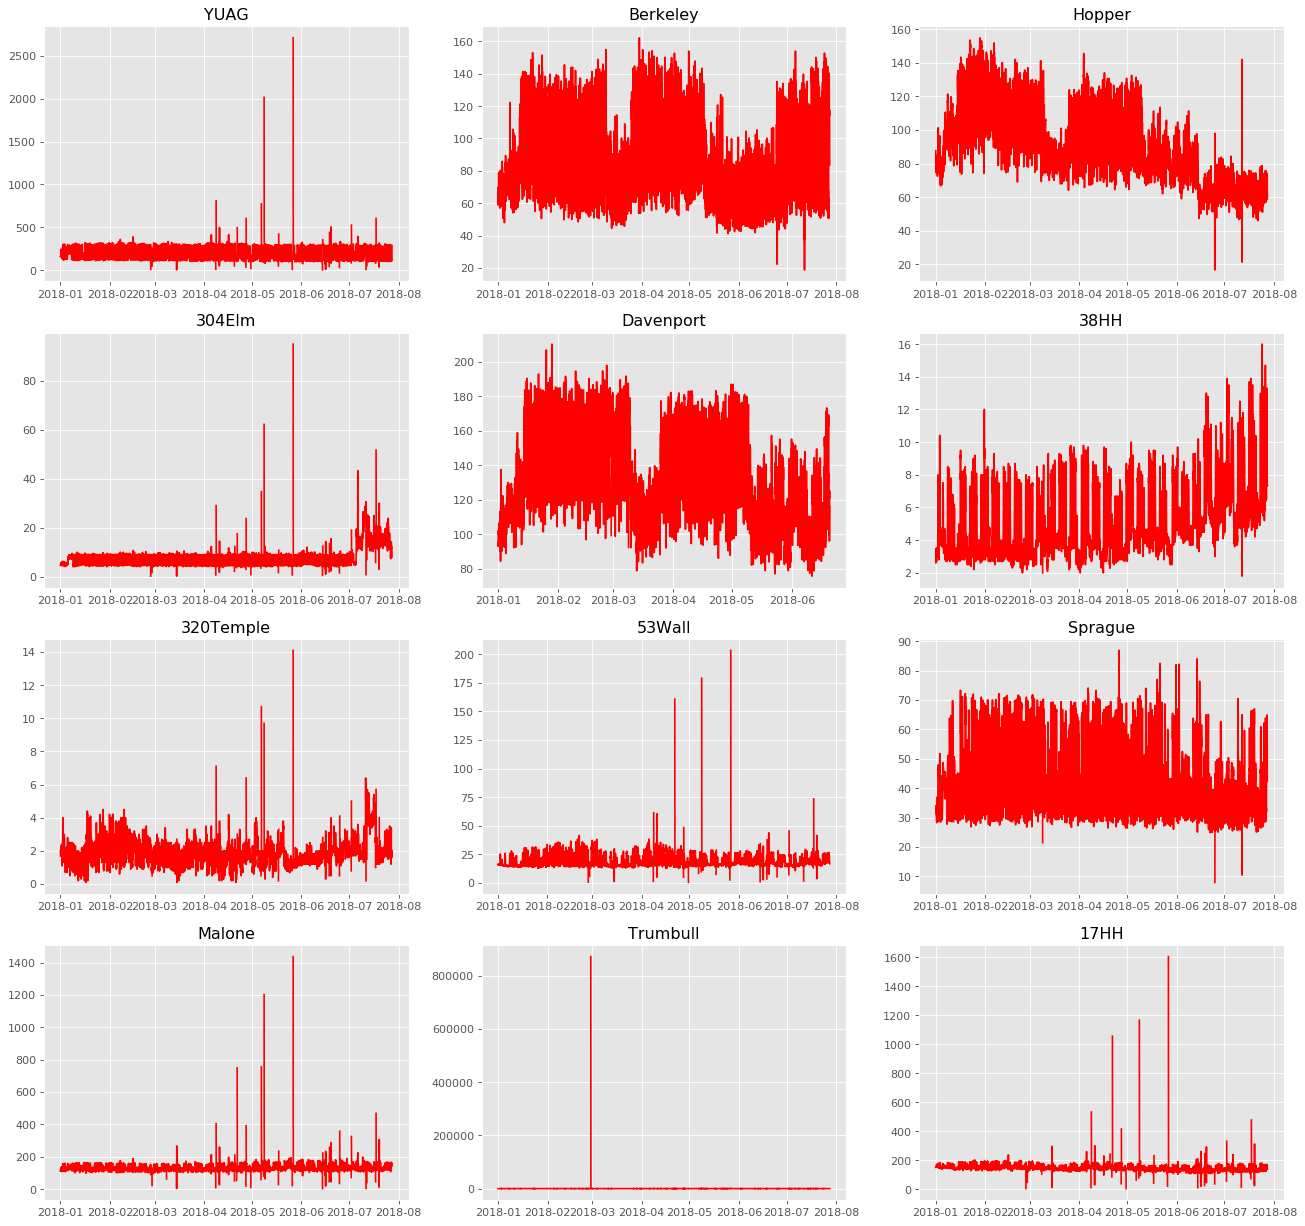

In [7]:
# creates a new dataframe for the demand values, drops the first row
demand = raw.diff().drop(raw.index[0])

# saves head to replace later
demand_head = demand.head(5)

errors = demand.isnull().sum()
print(errors)

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

In [8]:
# Remove huge statistical outliers
demand = demand.where(demand > demand.median() - 5*demand.std())
demand = demand.where(demand < demand.median() + 10*demand.std())


new_errors = demand.isnull().sum() - errors
print(new_errors)
errors = demand.isnull().sum()

YUAG         2
Berkeley     0
Hopper       0
304Elm       3
Davenport    0
38HH         0
320Temple    2
53Wall       4
Sprague      0
Malone       4
Trumbull     1
17HH         4
dtype: int64


/Users/kevinkoste/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7772: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors, try_cast=try_cast)


YUAG          159
Berkeley       14
Hopper         15
304Elm        175
Davenport     918
38HH           22
320Temple     314
53Wall        580
Sprague        33
Malone        167
Trumbull      306
17HH         1059
dtype: int64


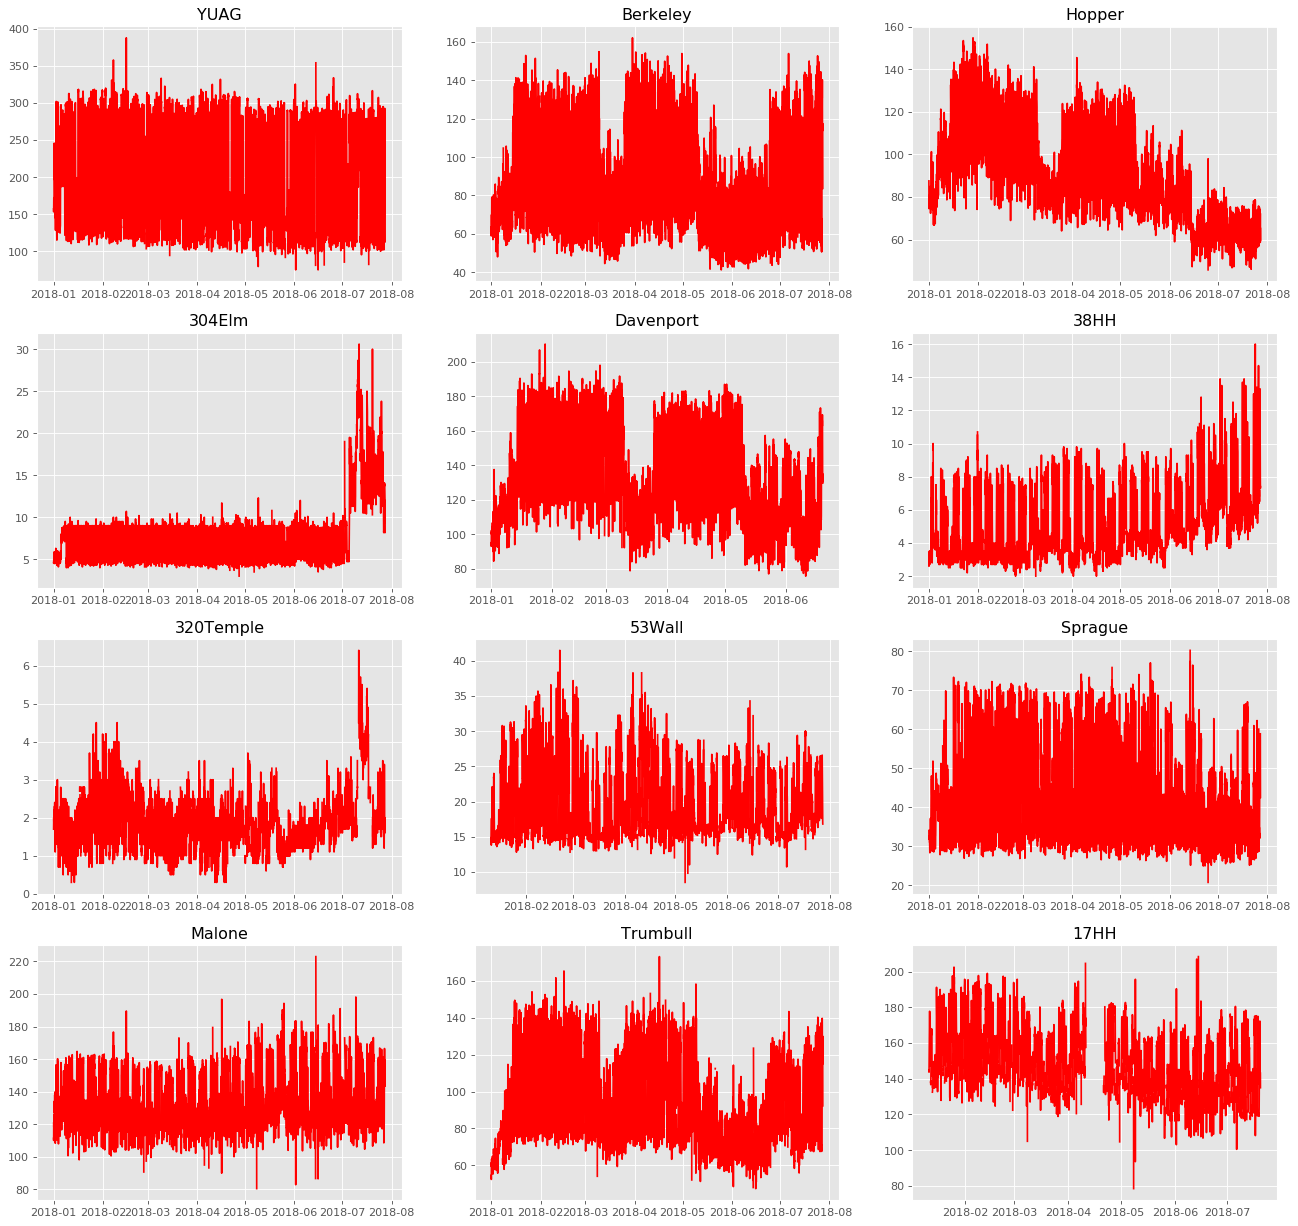

In [9]:
# remove errors by rolling min and max within 10-day chunks
chunk_size = 240
i=0

while i < len(demand):
    end = i+chunk_size
    if end > len(demand): end = len(demand)
    demand[i:end].where(demand[i:end] > demand[i:end].rolling(24).min().median()*0.7, inplace=True)
    demand[i:end].where(demand[i:end] < demand[i:end].rolling(24).max().median()*1.3, inplace=True)
    i = i+chunk_size


new_errors = demand.isnull().sum() - errors
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

YUAG          161
Berkeley       14
Hopper         15
304Elm        178
Davenport     918
38HH           22
320Temple     316
53Wall        584
Sprague        33
Malone        171
Trumbull      307
17HH         1063
dtype: int64

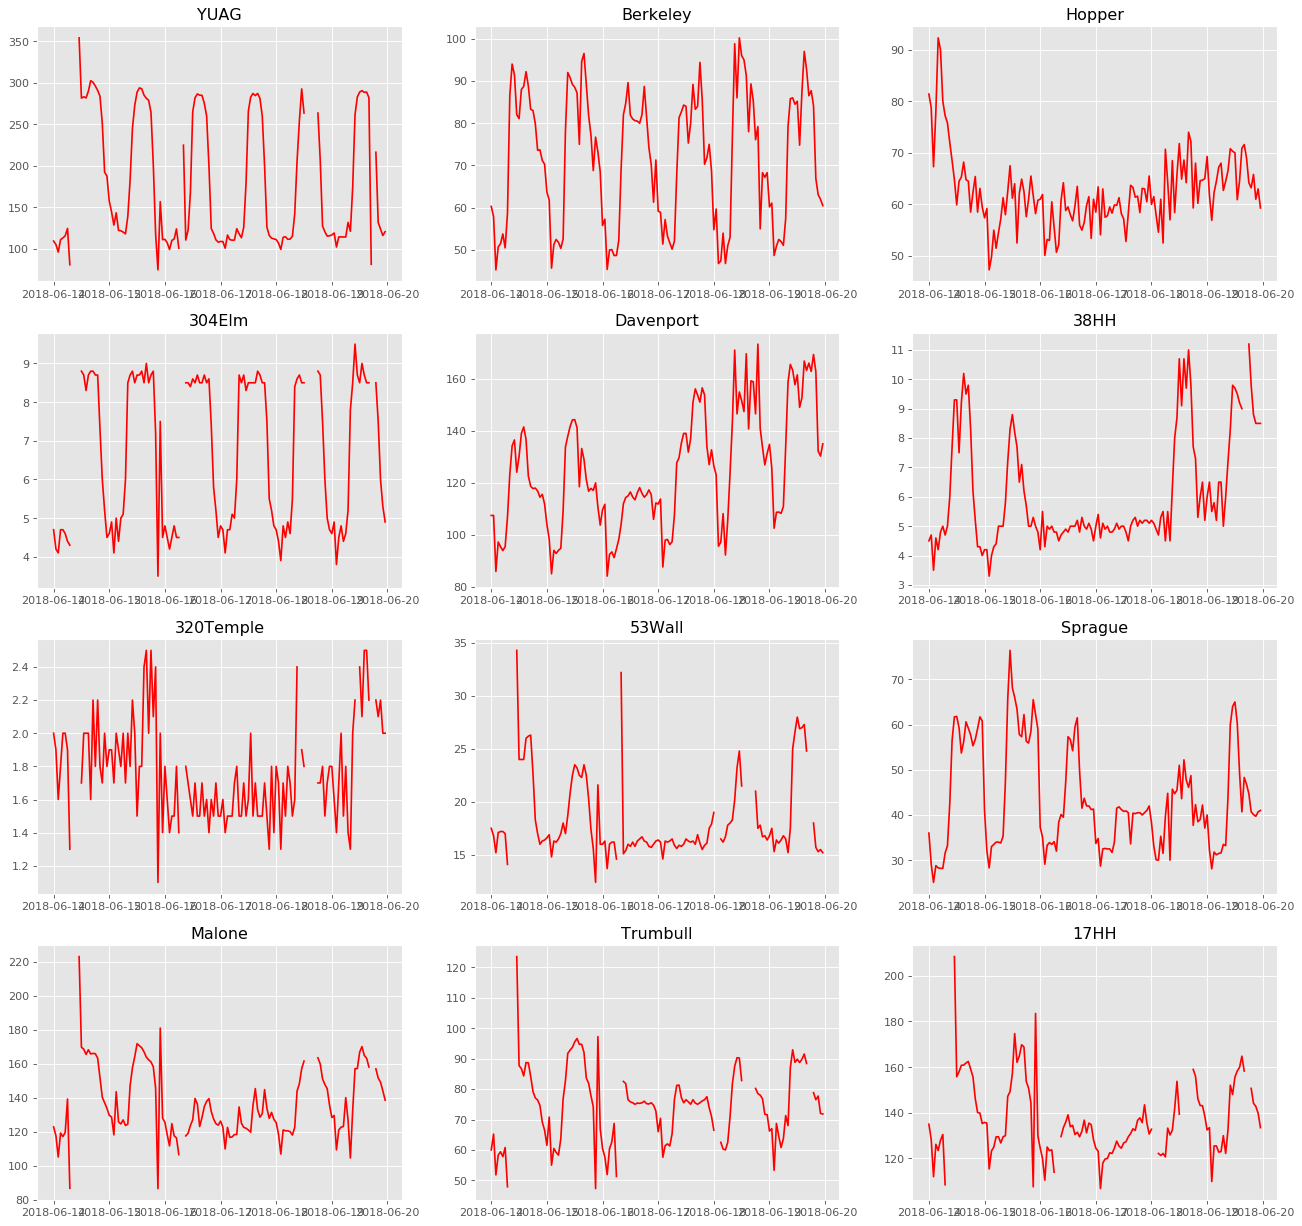

In [10]:
new_errors = demand.isnull().sum() - errors
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-06-14 00:00:00','2018-06-20 00:00:00')

YUAG          161
Berkeley       14
Hopper         15
304Elm        178
Davenport     918
38HH           22
320Temple     316
53Wall        584
Sprague        33
Malone        171
Trumbull      307
17HH         1063
dtype: int64

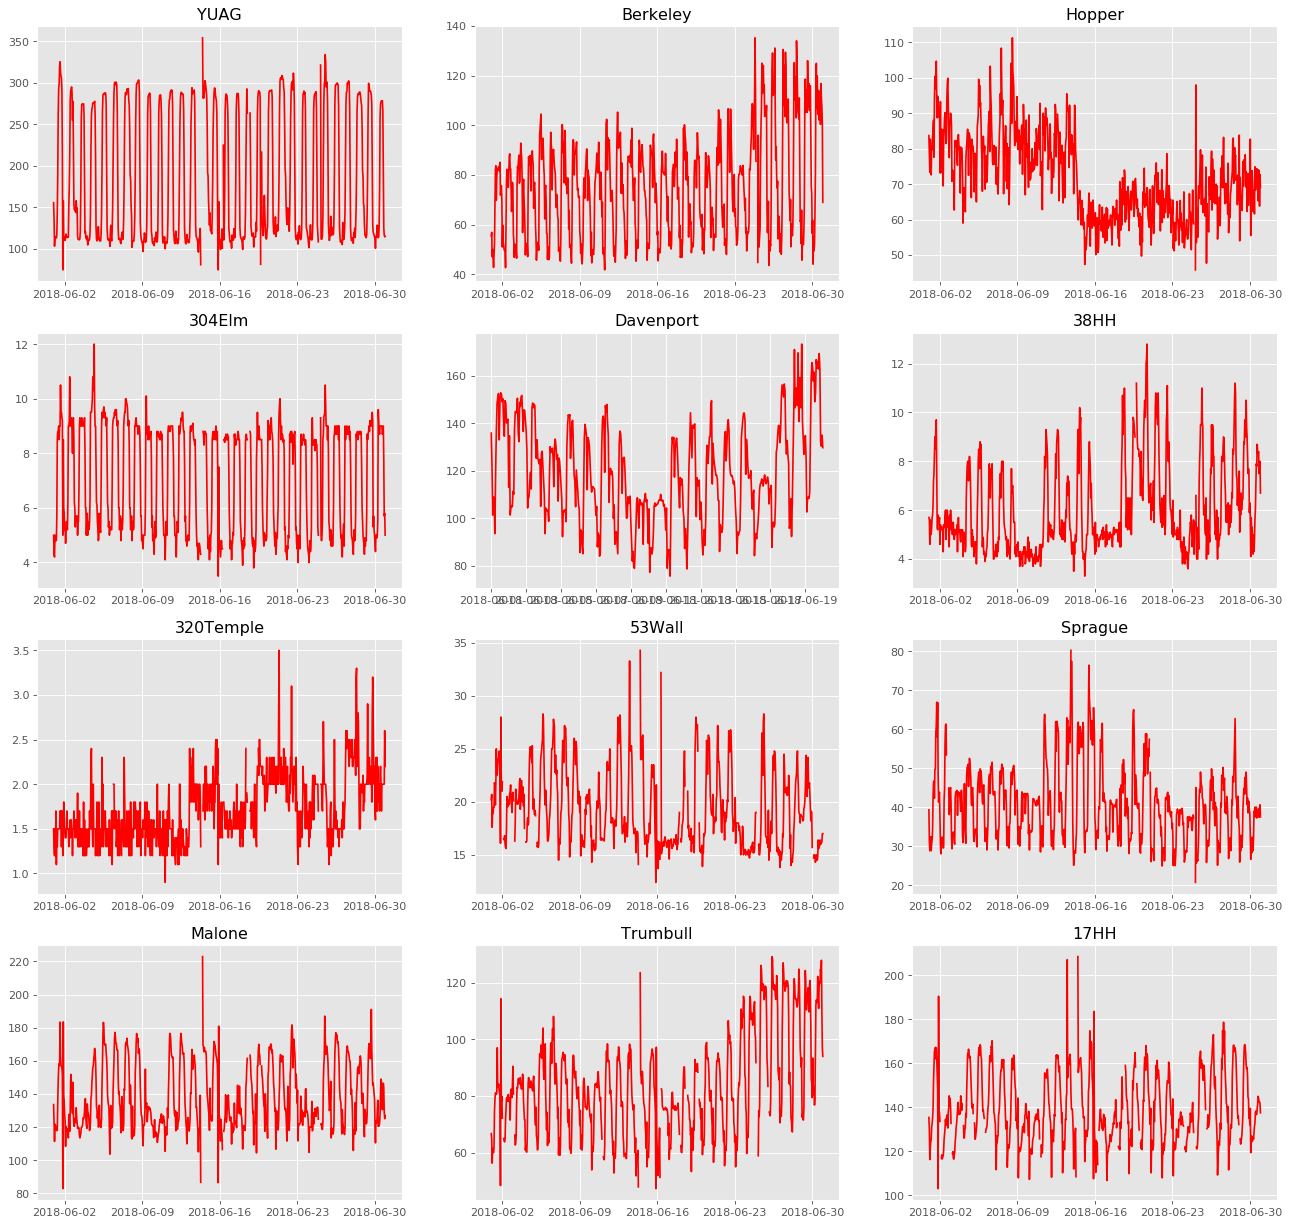

In [12]:
fn.plot_all(demand,'2018-06-01 00:00:00','2018-07-01 00:00:00')
demand.isnull().sum()

# Imputation

In [ ]:
# add gap_checking stuff here... fuck

In [14]:
# final interpolation of demand values after dropping outliers
# this needs to be replaced with FFT for any gaps longer than ~6 hours
demand = demand.interpolate(method='time',limit=24)

print(demand.isnull().sum())

# returns index labels where nan values appear for a certain column
nan_index = demand['304Elm'].index[demand['304Elm'].apply(np.isnan)]
print(nan_index)

YUAG           0
Berkeley       0
Hopper         0
304Elm         0
Davenport    887
38HH           0
320Temple      6
53Wall       240
Sprague        0
Malone         0
Trumbull       0
17HH         627
dtype: int64
DatetimeIndex([], dtype='datetime64[ns]', freq='H')


In [15]:
# replace head for final export
demand.iloc[[0,1,2,3,4],:] = demand_head

# final = demand.copy(deep=True).round(1)

final.to_csv('energy_clean.csv')

NameError: name 'final' is not defined

# unused code below

In [ ]:
# # this cell removes all consumption values BELOW first value

# # creates dataframe of repeated minimum (first) values, pretty workaroundy
# raw_mins = raw.copy(deep=True)
# raw_mins.loc[:,:] = raw.loc['2018-01-01 00:00:00'].values

# # sets all violating values to NaN
# raw = raw.where(raw >= raw_mins)

# # this unused line was an attempt to find outliers using std ranges
# # raw = raw.where(raw > raw.median() - 2*raw.std()).where(raw < raw.median() + 2*raw.std())

# raw.isnull().sum()

In [ ]:
# trying to plot daily average curves for buildings... matplotlib might support this somehow or i can write a fn

# raw = raw.iloc[:,[0]]

# raw['day'] = raw.index.day
# raw['hour'] = raw.index.hour

# raw_by_day = raw.resample('h').mean()
# raw_by_day = raw_by_day.set_index(['day','hour']).unstack('day')
# raw_by_day

In [ ]:
# OLD ATTEMPT to find outliers using tuner values

# comp = demand.take([1], axis=1)
# comp['rolling'] = comp.loc[:,'Berkeley'].rolling(4,min_periods=1).median()
# # demand.rolling(4,min_periods=1).median()*0.5

# comp['rollmin'] = comp.loc[:,'Berkeley'].rolling(8,min_periods=6).min()

# # fn.plot_all(comp,'2018-03-14 00:00:00','2018-06-20 00:00:00')

# fn.plot_feature(comp,'rollmin','2018-01-02 00:00:00','2018-07-25 00:00:00')

# comp['rollmin'].median()-comp['rollmin'].std()

# max_tuner = 1 # here i want higher values clipping more points
# min_tuner = 1

# # demand.std()/demand.median() # here high values indicate volatile, 

# demand = demand.where(demand > demand.rolling(8,min_periods=4).min() - (min_tuner - demand.std()/demand.median()))
                      
# demand = demand.where(demand < demand.rolling(8,min_periods=4).max() + (max_tuner - demand.std()/demand.median()))

# fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
# demand.isnull().sum()

In [ ]:
# iterative (bad performance) solution for single spikes, could work as supplement

# k='YUAG'

# for i in range(len(demand)-1):
#     if (abs(demand.pct_change()[k][i]) > 0.5) & (abs(demand.pct_change()[k][i+1]) > 0.5):
#         demand[k][i] = np.NaN

# fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
# demand.isnull().sum()

